# Part 1: Build CpG Detector

Here we have a simple problem, given a DNA sequence (of N, A, C, G, T), count the number of CpGs in the sequence (consecutive CGs).

We have defined a few helper functions / parameters for performing this task.

We need you to build a LSTM model and train it to complish this task in PyTorch.

A good solution will be a model that can be trained, with high confidence in correctness.

In [1]:
from typing import Sequence
from functools import partial
import random
import torch
import numpy as np
import random

In [2]:
# DO NOT CHANGE HERE
def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(13)

# Use this for getting x label
def rand_sequence(n_seqs: int, seq_len: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        yield [random.randint(0, 4) for _ in range(seq_len)]

# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs

# Alphabet helpers   
alphabet = 'NACGT'
dna2int = { a: i for a, i in zip(alphabet, range(5))}
int2dna = { i: a for a, i in zip(alphabet, range(5))}

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [3]:
#equivalent of tensorflow categorical in torch
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [4]:
# we prepared two datasets for training and evaluation
# training data scale we set to 2048
# we test on 512

def prepare_data(num_samples=100):
    # prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    # step 1
    X_dna_seqs_train = list(rand_sequence(num_samples))
    """
    hint:
        1. You can check X_dna_seqs_train by print, the data is ids which is your training X 
        2. You first convert ids back to DNA sequence
        3. Then you run count_cpgs which will yield CGs counts - this will be the labels (Y)
    """
    #step2
    temp = ["".join(intseq_to_dnaseq(x)) for x in X_dna_seqs_train] # use intseq_to_dnaseq here to convert ids back to DNA seqs
    #step3
    y_dna_seqs = [count_cpgs(x) for x in temp] # use count_cpgs here to generate labels with temp generated in step2
    #step4 
    onehot_encodings = [to_categorical(x,num_classes=5) for x in X_dna_seqs_train] #create onehot encodings
    #step5
    X_dna_seqs_train = torch.tensor(onehot_encodings, dtype=torch.float)
    y_dna_seqs = torch.tensor(y_dna_seqs, dtype=torch.float)
    
    return X_dna_seqs_train, y_dna_seqs
    
train_x, train_y = prepare_data(2048)
test_x, test_y = prepare_data(512)

C:\Users\susinghrawat\AppData\Local\Temp\ipykernel_36448\1219703697.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  X_dna_seqs_train = torch.tensor(onehot_encodings, dtype=torch.float)


In [5]:
print(train_x.shape)
print(train_y.shape)

torch.Size([2048, 128, 5])
torch.Size([2048])


In [6]:
# some config
LSTM_HIDDEN = 128
LSTM_LAYER = 1
batch_size = 32
learning_rate = 0.001
epoch_num = 300

In [7]:
from torch.utils.data import TensorDataset, DataLoader
# create data loader
train_data_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(TensorDataset(test_x, test_y), batch_size=batch_size, shuffle=False)

In [8]:
# Model
class CpGPredictor(torch.nn.Module):
    ''' Simple model that uses a LSTM to count the number of CpGs in a sequence '''
    def __init__(self):
        super(CpGPredictor, self).__init__()
        # TODO complete model, you are free to add whatever layers you need here
        # We do need a lstm and a classifier layer here but you are free to implement them in your way
        self.lstm = torch.nn.LSTM(5, LSTM_HIDDEN, LSTM_LAYER, batch_first=True)
        self.classifier = torch.nn.Linear(LSTM_HIDDEN, 1)

    def forward(self, x):
        # TODO complete forward function
        output, _ = self.lstm(x)
        output = output[:, -1, :] #choosing last timestep from each batch
        logits = self.classifier(output)
        return logits

In [9]:
# init model / loss function / optimizer etc.
model = CpGPredictor()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# training (you can modify the code below)
t_loss = 0
val_loss = 0
training_loss = []
validation_loss = []

model.train()
model.zero_grad()
for i in range(epoch_num):
    for batch in train_data_loader:
        inp, target = batch
        out = model(inp)
        out = out.squeeze()
        optimizer.zero_grad()
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        t_loss += loss.item() 
    
    if i%10==0:
        #compute validation error
        model.eval()
        with torch.no_grad():
            out = model(inp)
            out = out.squeeze()
            loss = loss_fn(out, target)
            val_loss+=loss.item()

        training_loss.append(t_loss)
        validation_loss.append(val_loss)
        print("Epoch:",i,"Training Loss:",t_loss,"Validation Loss:",val_loss)
        val_loss = 0
    t_loss = 0

Epoch: 0 Training Loss: 584.6737458705902 Validation Loss: 4.6878204345703125
Epoch: 10 Training Loss: 268.827424287796 Validation Loss: 3.4096262454986572
Epoch: 20 Training Loss: 268.4294295310974 Validation Loss: 5.276222229003906
Epoch: 30 Training Loss: 267.291357755661 Validation Loss: 4.4912848472595215
Epoch: 40 Training Loss: 268.7998846769333 Validation Loss: 3.919861316680908
Epoch: 50 Training Loss: 264.7804329395294 Validation Loss: 3.9704513549804688
Epoch: 60 Training Loss: 261.8662860393524 Validation Loss: 3.3661792278289795
Epoch: 70 Training Loss: 257.030246257782 Validation Loss: 4.0688066482543945
Epoch: 80 Training Loss: 179.45953905582428 Validation Loss: 2.4652342796325684
Epoch: 90 Training Loss: 8.03344694711268 Validation Loss: 0.1407589614391327
Epoch: 100 Training Loss: 2.942875064909458 Validation Loss: 0.016522293910384178
Epoch: 110 Training Loss: 2.528950863517821 Validation Loss: 0.016766704618930817
Epoch: 120 Training Loss: 1.0915017542429268 Validat

<function matplotlib.pyplot.show(close=None, block=None)>

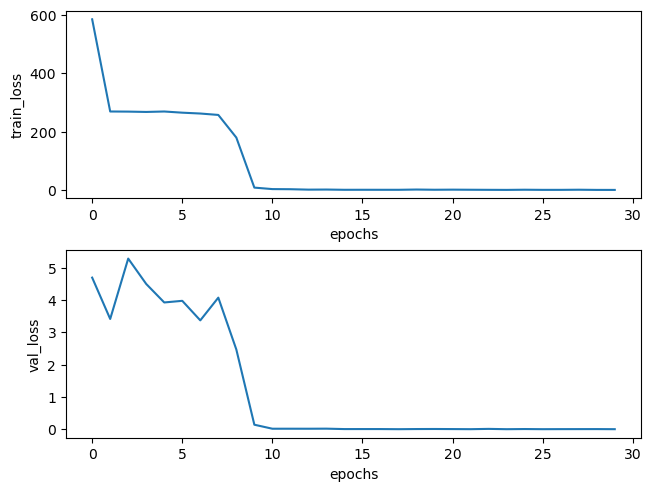

In [11]:
from matplotlib import pyplot as plt
fig, (ax1,ax2) = plt.subplots(2,1, layout='constrained')
ax1.plot(training_loss)
ax1.set_ylabel('train_loss')
ax1.set_xlabel('epochs')
ax2.plot(validation_loss)
ax2.set_ylabel('val_loss')
ax2.set_xlabel('epochs')
plt.show

In [12]:
# eval (you can modify the code below)
from sklearn.metrics import r2_score

model.eval()
res_gs = []
res_pred = []

with torch.no_grad():
    for batch in test_data_loader:
        inp, target = batch
        out = model(inp)
        out = out.squeeze()
        res_gs.extend(target.tolist())
        res_pred.extend(out.tolist())
print(r2_score(res_gs,res_pred))

0.9993852384097482


In [13]:
torch.save(model, "trained_model/model_fixed_len_sequence.pt")

In [14]:
# #sample test
# sample_input = "NCACANNTNCGGAGGCGNA"
# seq = [x for x in dnaseq_to_intseq(sample_input)]
# oneh = [to_categorical(x,num_classes=5) for x in seq]
# sequence = torch.tensor(oneh, dtype=torch.float)
# sequence = sequence.unsqueeze(0)
# model.eval()
# with torch.no_grad():
#     out = model(sequence)
#     out = out.squeeze()
#     print(out)

# Part 2: what if the DNA sequences are not the same length

In [15]:
# hint we will need following imports
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [16]:
# DO NOT CHANGE HERE
random.seed(13)

# Use this for getting x label
def rand_sequence_var_len(n_seqs: int, lb: int=16, ub: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        seq_len = random.randint(lb, ub)
        yield [random.randint(1, 5) for _ in range(seq_len)]


# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs


# Alphabet helpers   
alphabet = 'NACGT'
dna2int = {a: i for a, i in zip(alphabet, range(1, 6))}
int2dna = {i: a for a, i in zip(alphabet, range(1, 6))}
dna2int.update({"pad": 0})
int2dna.update({0: "<pad>"})

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [17]:
# TODO complete the task based on the change
def prepare_data(num_samples=100, min_len=16, max_len=128):
    # TODO prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    #step 1
    X_dna_seqs_train = list(rand_sequence_var_len(num_samples, min_len, max_len))
    #step 2
    temp = ["".join(intseq_to_dnaseq(x)) for x in X_dna_seqs_train]
    #step3
    y_dna_seqs = [count_cpgs(x) for x in temp]
    #step4
    X_dna_seqs_train = [torch.LongTensor(x) for x in X_dna_seqs_train]
    X_dna_seqs_train_padding = pad_sequence(X_dna_seqs_train, batch_first=True, padding_value=dna2int['pad'])
    #step5
    X_dna_seqs_train_onehot_padding = [to_categorical(x,num_classes=6) for x in X_dna_seqs_train_padding] #create onehot encodings
    X_dna_seqs_train_onehot_padding = torch.tensor(X_dna_seqs_train_onehot_padding, dtype=torch.float) 
    y_dna_seqs = torch.tensor(y_dna_seqs, dtype=torch.float)
    
    return X_dna_seqs_train_onehot_padding, y_dna_seqs
    
    
min_len, max_len = 64, 128
train_x, train_y = prepare_data(2048, min_len, max_len)
test_x, test_y = prepare_data(512, min_len, max_len)

In [18]:
train_x.shape, train_y.shape

(torch.Size([2048, 128, 6]), torch.Size([2048]))

In [19]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, lists, labels) -> None:
        self.lists = lists
        self.labels = labels

    def __getitem__(self, index):
        return torch.tensor(self.lists[index]), self.labels[index]

    def __len__(self):
        return len(self.lists)

# this will be a collate_fn for dataloader to pad sequence  
#found the code from here --> https://www.codefull.org/2018/11/use-pytorchs-dataloader-with-variable-length-sequences-for-lstm-gru/
class PadSequence:
    def __call__(self, batch):
        # Let's assume that each element in "batch" is a tuple (data, label).
        # Sort the batch in the descending order
        sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
        # Get each sequence and pad it
        sequences = [x[0] for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=dna2int['pad'])
        # Also need to store the length of each sequence
        # This is later needed in order to unpad the sequences
        sequences_padded = torch.tensor(sequences_padded)
        lengths = torch.tensor([len(x) for x in sequences])
        # Don't forget to grab the labels of the *sorted* batch
        labels = torch.tensor([x[1] for x in sorted_batch])
        return sequences_padded, lengths, labels

In [21]:
# some config
LSTM_HIDDEN = 128
LSTM_LAYER = 1
batch_size = 32
learning_rate = 0.001
epoch_num = 300

In [22]:
from torch.utils.data import TensorDataset, DataLoader
# create data loader
train_data_loader = DataLoader(MyDataset(train_x, train_y), batch_size=batch_size, collate_fn=PadSequence(), shuffle=True)
test_data_loader = DataLoader(MyDataset(test_x, test_y), batch_size=batch_size, collate_fn=PadSequence(), shuffle=False)

In [23]:
#check shapes of input
for i in train_data_loader:
    print(i[0].shape)
    print(i[1].shape)
    break

torch.Size([32, 128, 6])
torch.Size([32])


C:\Users\susinghrawat\AppData\Local\Temp\ipykernel_36448\674878220.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.lists[index]), self.labels[index]
C:\Users\susinghrawat\AppData\Local\Temp\ipykernel_36448\674878220.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences_padded = torch.tensor(sequences_padded)


In [24]:
# Model
class CpGPredictor(torch.nn.Module):
    ''' Simple model that uses a LSTM to count the number of CpGs in a sequence '''
    def __init__(self):
        super(CpGPredictor, self).__init__()
        # TODO complete model, you are free to add whatever layers you need here
        # We do need a lstm and a classifier layer here but you are free to implement them in your way
        self.lstm = torch.nn.LSTM(6, LSTM_HIDDEN, LSTM_LAYER, batch_first=True)
        self.classifier = torch.nn.Linear(LSTM_HIDDEN, 1)

    def forward(self, x, x_length):
        ''' ChatGPT and google helped a lot in this one phew 
        (https://chat.openai.com/share/5aac1c10-60a4-4afb-ad6f-882e185969a2)
        '''
        # TODO complete forward function
        x_pack = pack_padded_sequence(x,x_length, batch_first=True, enforce_sorted=True)
        x_padded, _ = pad_packed_sequence(x_pack, batch_first=True)
        output, _ = self.lstm(x_padded)
        output = output[:, -1, :] #choosing last timestep from each batch
        logits = self.classifier(output)
        return logits

In [25]:
# init model / loss function / optimizer etc.
model = CpGPredictor()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
# training (you can modify the code below)
t_loss = 0
val_loss = 0
training_loss = []
validation_loss = []

model.train()
model.zero_grad()
for i in range(epoch_num):
    for batch in train_data_loader:
        inp, length, target = batch
        out = model(inp,length)
        out = out.squeeze()
        optimizer.zero_grad()
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        t_loss += loss.item() 
    
    if i%10==0:
        #compute validation error
        model.eval()
        with torch.no_grad():
            out = model(inp, length)
            out = out.squeeze()
            loss = loss_fn(out, target)
            val_loss+=loss.item()
    
        training_loss.append(t_loss)
        validation_loss.append(val_loss)
        print("Epoch:",i,"Training Loss:",t_loss,"Validation Loss:",val_loss)
        val_loss = 0
    t_loss = 0

C:\Users\susinghrawat\AppData\Local\Temp\ipykernel_36448\674878220.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.lists[index]), self.labels[index]
C:\Users\susinghrawat\AppData\Local\Temp\ipykernel_36448\674878220.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences_padded = torch.tensor(sequences_padded)


Epoch: 0 Training Loss: 416.2323350906372 Validation Loss: 3.8909389972686768
Epoch: 10 Training Loss: 234.6464604139328 Validation Loss: 1.8835800886154175
Epoch: 20 Training Loss: 206.66390240192413 Validation Loss: 2.9316611289978027
Epoch: 30 Training Loss: 191.4844170808792 Validation Loss: 2.812187433242798
Epoch: 40 Training Loss: 15.919064499437809 Validation Loss: 0.1751340925693512
Epoch: 50 Training Loss: 2.7332090493291616 Validation Loss: 0.03850292041897774
Epoch: 60 Training Loss: 2.150206350721419 Validation Loss: 0.007447096984833479
Epoch: 70 Training Loss: 0.8967099077999592 Validation Loss: 0.009058049879968166
Epoch: 80 Training Loss: 1.328771028202027 Validation Loss: 0.018567301332950592
Epoch: 90 Training Loss: 1.001737529411912 Validation Loss: 0.03285231441259384
Epoch: 100 Training Loss: 1.2525408025830984 Validation Loss: 0.008755188435316086
Epoch: 110 Training Loss: 1.0542867635376751 Validation Loss: 0.012112352065742016
Epoch: 120 Training Loss: 0.342950

In [27]:
# eval (you can modify the code below)
from sklearn.metrics import r2_score

model.eval()
res_gs = []
res_pred = []

with torch.no_grad():
    for batch in test_data_loader:
        inp, length, target = batch
        out = model(inp, length)
        out = out.squeeze()
        res_gs.extend(target.tolist())
        res_pred.extend(out.tolist())
print(r2_score(res_gs,res_pred))

0.9995178676873524


C:\Users\susinghrawat\AppData\Local\Temp\ipykernel_36448\674878220.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.lists[index]), self.labels[index]
C:\Users\susinghrawat\AppData\Local\Temp\ipykernel_36448\674878220.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences_padded = torch.tensor(sequences_padded)


In [28]:
torch.save(model, "trained_model/model_variable_len_sequence.pt")

## Model inference pipeline

In [38]:
def convert_seq_to_desired_padding(sequence, desired_length=128):
    pad_right = desired_length - len(sequence)
    sequence.extend([dna2int["pad"]]*pad_right)
    return sequence

def inference_for_single_sequence(sequence, maxlen):
    X_dna_seqs = sequence
    temp = ["".join(intseq_to_dnaseq(x)) for x in X_dna_seqs]
    y_dna_seqs = [count_cpgs(x) for x in temp]
    X_dna_seqs_padding = [convert_seq_to_desired_padding(x, desired_length=maxlen) for x in X_dna_seqs]
    X_dna_seqs_onehot_padding = [to_categorical(x,num_classes=6) for x in X_dna_seqs_padding] 
    X_dna_seqs_onehot_padding = torch.tensor(X_dna_seqs_onehot_padding, dtype=torch.float) 
    y_dna_seqs = torch.tensor(y_dna_seqs, dtype=torch.float)
    
    return X_dna_seqs_onehot_padding, y_dna_seqs


def evaluation_for_single_sequence(dna_seq: str):
    seq = [[x for x in dnaseq_to_intseq(dna_seq)]]
    sample_x, sample_y = inference_for_single_sequence(seq, 128)
    dl = DataLoader(MyDataset(sample_x,sample_y), batch_size=1, collate_fn=PadSequence())
    
    model.eval()
    res_gs = []
    res_pred = []

    with torch.no_grad():
        for batch in dl:
            inp, length, target = batch
            out = model(inp, length)
            out = out.squeeze()
            return out.item()

In [39]:
evaluation_for_single_sequence(dna_seq= "NCACANNTNCGGAGGCA")

C:\Users\susinghrawat\AppData\Local\Temp\ipykernel_36448\674878220.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.lists[index]), self.labels[index]
C:\Users\susinghrawat\AppData\Local\Temp\ipykernel_36448\674878220.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences_padded = torch.tensor(sequences_padded)


1.0529332160949707